In [1]:
import xarray as xr
from pathlib import Path
import seaborn as sns
from sklearn import preprocessing
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn import linear_model, svm, ensemble, neural_network, decomposition
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

from lightgbm import LGBMRegressor, plot_importance, plot_split_value_histogram

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train_ds = xr.open_dataset('train_set.nc', engine='h5netcdf')

In [3]:
yvar = 'cloud_top_altitude'
calipso_mask = train_ds[yvar].values

In [4]:
def classify(arr):
    # 0 = no, 1 = low, 2 = mid, 3 = high, 4 = deep, 
    narr = np.zeros(arr.shape)
    narr[arr == 8] = 0
    narr[arr < 4] = 1
    narr[(arr == 4) | (arr == 5)] = 2
    narr[arr == 6] = 3
    narr[arr == 7] = 4
    return narr

In [5]:
vars_ = [v for v in train_ds.variables.keys() if 'CMI_C' in v] + ['cloud_type']

%time df = train_ds[vars_].isel(near=0).to_dataframe()
df = df.drop(columns=[c for c in df.columns if c not in vars_])
df['cloud_type'] = classify(df['cloud_type'].astype(int))

CPU times: user 633 ms, sys: 34 ms, total: 667 ms
Wall time: 667 ms


In [6]:
import pickle
with open('cloud_mask.pkl', 'rb') as f:
    mask_model = pickle.load(f)
with open('cloud_type.pkl', 'rb') as f:
    type_model = pickle.load(f)
    

In [7]:
nans = df.isna().any(axis=1) 
X = df[~nans]
y = calipso_mask[X.index]
ynan = np.isnan(y)
y[ynan] = 0

X.shape, y.shape

((341267, 17), (341267,))

In [8]:
val_ds = xr.open_dataset('validate_set.nc', engine='h5netcdf')
#limit = (val_ds.cloud_type == 8) | (val_ds.cloud_type == 3)
val_df = val_ds.isel(near=0)[vars_].to_dataframe()#[limit.data]

val_df = val_df.drop(columns=[c for c in val_df.columns if c not in vars_])
val_df['cloud_type'] = classify(val_df['cloud_type'].astype(int))
val_nans = val_df.isna().any(axis=1)  
X_val = val_df[~val_nans][df.columns]
y_val = val_ds[yvar].values[X_val.index]
y_val[np.isnan(y_val)] = 0
X_val.shape, y_val.shape

((76693, 17), (76693,))

In [9]:
#val_nans |= (val_df['cloud_type'] == 0) 
#val_nans |= np.isnan(val_ds[yvar].values)
tdf = val_df.copy()
tnan = tdf.isna().any(axis=1)
tind = tdf.index[~tnan]
cloud_prob = mask_model.predict_proba(tdf[~tnan].values[:, :-1])
#type_probs = type_model.predict_proba(tdf[~tnan].values[:, :-1])
tdf['cloud_type'] = pd.Series(cloud_prob[:, 1] >= 0.5, index=tind, dtype=float) # 0 clear, 1 cloudy
other = pd.Series(type_model.predict(tdf[~tnan].values[:, :-1]), index=tind)
tdf['cloud_type'] *= other

Xt = tdf[~tnan][df.columns]
yt = val_ds[yvar].values[Xt.index]
ynan = np.isnan(yt)
yt[ynan] = 0


In [10]:

reg = neural_network.MLPRegressor(activation='relu', alpha=1e-4, hidden_layer_sizes=(20, ),
                                  tol=1e-4, solver='adam', verbose=False)
model = Pipeline([
    ('scaler', preprocessing.RobustScaler()),
    ('pca', decomposition.PCA(whiten=True)),
    #('scaler', preprocessing.QuantileTransformer(output_distribution='normal')),
    #('poly', preprocessing.PolynomialFeatures(degree=2, interaction_only=False)),
    ('reg', reg)
])
    
%time model.fit(X.values, y)

CPU times: user 42.7 s, sys: 1.64 s, total: 44.3 s
Wall time: 43.6 s


Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('reg',
                 MLPRegressor(activation='relu', alpha=0.0001,
                              batch_size='auto', beta_1=0.9, beta_2=0.999,
                              early_stopping=False, epsilon=1e-08,
                              hidden_layer_sizes=(20,),
                              learning_rate='constant',
                              learning_rate_init=0.001, max_fun=15000,
                              max_iter=200, momentum=0.9, n_iter_no_change=10,
                              nesterovs_momentum=True, power_t=0.5,
                              random_state=None,

In [11]:
%%time
model.score(X, y), model.score(X_val, y_val), model.score(Xt, yt)

CPU times: user 624 ms, sys: 531 ms, total: 1.16 s
Wall time: 222 ms


(0.9801244404702194, 0.9804785330616015, 0.6471255265215414)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PredictionError(alpha=0.01,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f299d528ef0>,
                bestfit=True, identity=True, is_fitted='auto', model=None,
                shared_limits=True)

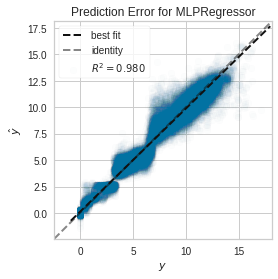

In [12]:
prediction_error(model, X, y, alpha=0.01)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PredictionError(alpha=0.05,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2997a8bcf8>,
                bestfit=True, identity=True, is_fitted='auto', model=None,
                shared_limits=True)

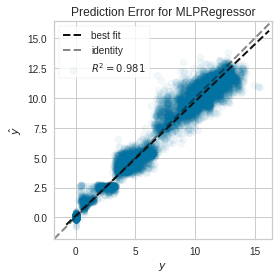

In [22]:
prediction_error(model, X_val, y_val, is_fitted=True, alpha=0.05)

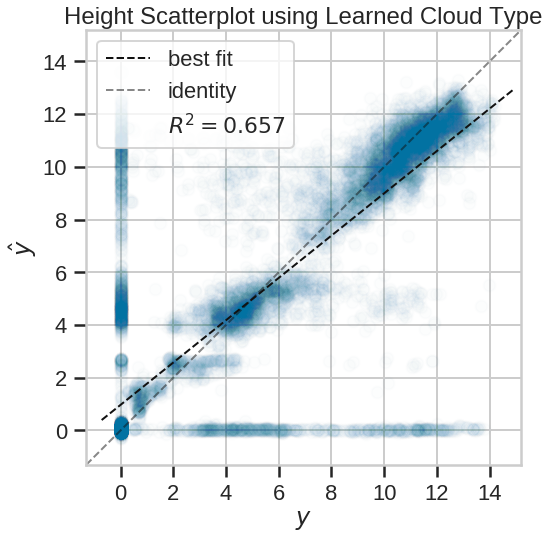

In [27]:
import seaborn as sns
with sns.plotting_context('poster'):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    prediction_error(model, Xt, yt, is_fitted=True, alpha=0.01, ax=ax)
    ax.set_title('Height Scatterplot using Learned Cloud Type')
    fig.savefig('height_scatter.png', dpi=300)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f29985db400>,
              hist=True, is_fitted='auto', line_color=None, model=None,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

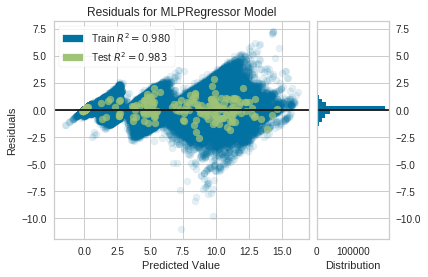

In [15]:
%matplotlib inline
residuals_plot(model, X, y, test_size=1e-3, train_alpha=0.1)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f29983c0cc0>,
              hist=True, is_fitted='auto', line_color=None, model=None,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

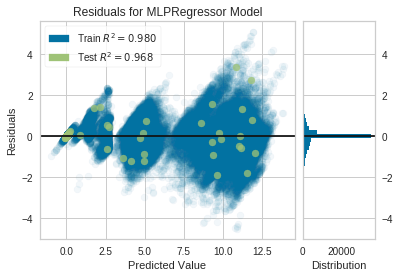

In [16]:
%matplotlib inline
residuals_plot(model, X_val, y_val, is_fitted=True, test_size=1e-3, train_alpha=0.05)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2997cb4a90>,
              hist=True, is_fitted='auto', line_color=None, model=None,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

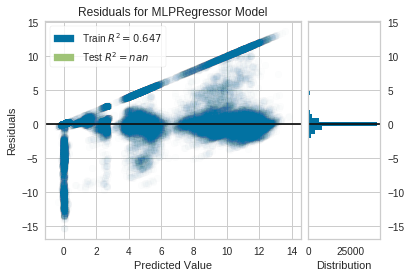

In [21]:
%matplotlib inline
residuals_plot(model, Xt, yt, is_fitted=True, test_size=1, test_alpha=0, train_alpha=0.01)

In [18]:
import pickle
with open('height.pkl', 'wb') as f:
    pickle.dump(model, f)